In [37]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models

# Load and preprocess the dataset
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
    return df_grouped

# Ensure all generation types are represented for every date
def standardize_generation_types(df, unique_types):
    all_dates = df['date'].unique()
    standardized_rows = [
        {'date': date, 'generation_type': g_type, 'megawatt_hours': 0}
        for date in all_dates
        for g_type in unique_types
        if g_type not in df[df['date'] == date]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

# Load the dataset
filepath = r'data\processed\yukon_energy.csv'
df_grouped = load_and_preprocess_data(filepath)

# Identify unique generation types and standardize the data
unique_generation_types = df_grouped['generation_type'].unique()
df_standardized = standardize_generation_types(df_grouped, unique_generation_types)

# Pivot the data for time-series analysis
df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)


In [38]:
# Scale the data
def scale_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

# Scale the pivoted data
data_scaled, scaler = scale_data(df_pivot)

In [39]:
# Create input-output sequences for time-series data
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Define the number of time steps (look-back period)
n_steps = 36

# Create full sequences
X, y = create_sequences(data_scaled, n_steps)

# Split into training and testing sets
test_size = 24  # Assuming monthly data, 24 months = 2 years
train_data, test_data = data_scaled[:-test_size], data_scaled[-test_size - n_steps:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

In [40]:
# Build a Temporal Convolutional Network (TCN) model
def build_tcn(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(256, kernel_size=3, padding='causal', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout1D(0.2)(x)
    for _ in range(8):
        x = layers.Conv1D(512, kernel_size=5, padding='causal', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.SpatialDropout1D(0.3)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(output_shape, activation='linear')(x)
    return models.Model(inputs, outputs)

# Define input and output shapes
input_shape = (n_steps, X_train.shape[2])
output_shape = y_train.shape[1]

# Build and compile the TCN model
tcn_model = build_tcn(input_shape, output_shape)
tcn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = tcn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)

Epoch 1/50
4/4 - 8s - loss: 0.2724 - mae: 0.4024 - val_loss: 0.1159 - val_mae: 0.1990 - 8s/epoch - 2s/step
Epoch 2/50
4/4 - 5s - loss: 0.3560 - mae: 0.4709 - val_loss: 0.1118 - val_mae: 0.2305 - 5s/epoch - 1s/step
Epoch 3/50
4/4 - 5s - loss: 0.3609 - mae: 0.4616 - val_loss: 0.0845 - val_mae: 0.1940 - 5s/epoch - 1s/step
Epoch 4/50
4/4 - 5s - loss: 0.2671 - mae: 0.4087 - val_loss: 0.1098 - val_mae: 0.2512 - 5s/epoch - 1s/step
Epoch 5/50
4/4 - 4s - loss: 0.1929 - mae: 0.3482 - val_loss: 0.1084 - val_mae: 0.2650 - 4s/epoch - 1s/step
Epoch 6/50
4/4 - 4s - loss: 0.1429 - mae: 0.3052 - val_loss: 0.0875 - val_mae: 0.2184 - 4s/epoch - 1s/step
Epoch 7/50
4/4 - 4s - loss: 0.0897 - mae: 0.2372 - val_loss: 0.0789 - val_mae: 0.1985 - 4s/epoch - 1s/step
Epoch 8/50
4/4 - 4s - loss: 0.0732 - mae: 0.2101 - val_loss: 0.1276 - val_mae: 0.2950 - 4s/epoch - 1s/step
Epoch 9/50
4/4 - 4s - loss: 0.0650 - mae: 0.2006 - val_loss: 0.2345 - val_mae: 0.3574 - 4s/epoch - 1s/step
Epoch 10/50
4/4 - 4s - loss: 0.0441 -

1/1 [==============================] - 0s 392ms/step


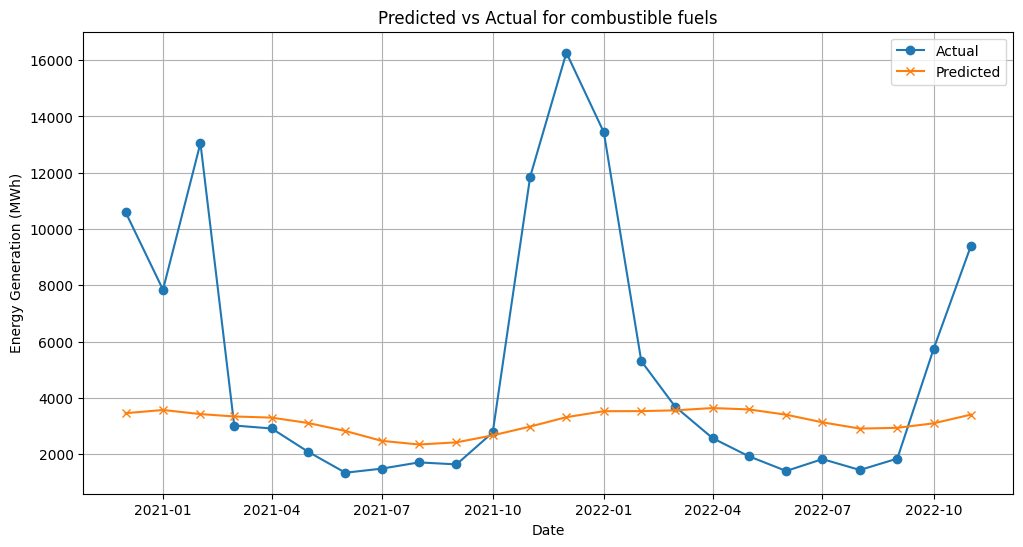

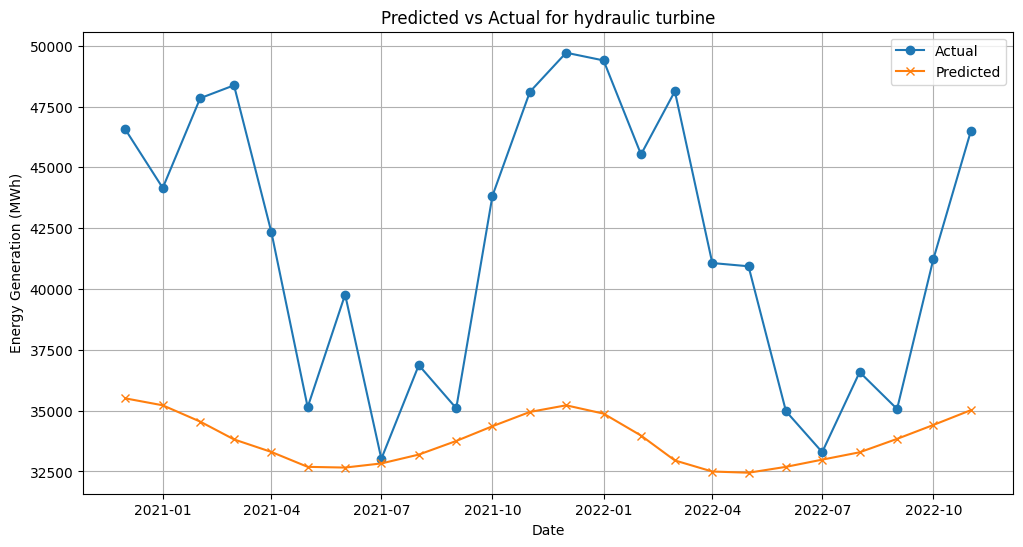

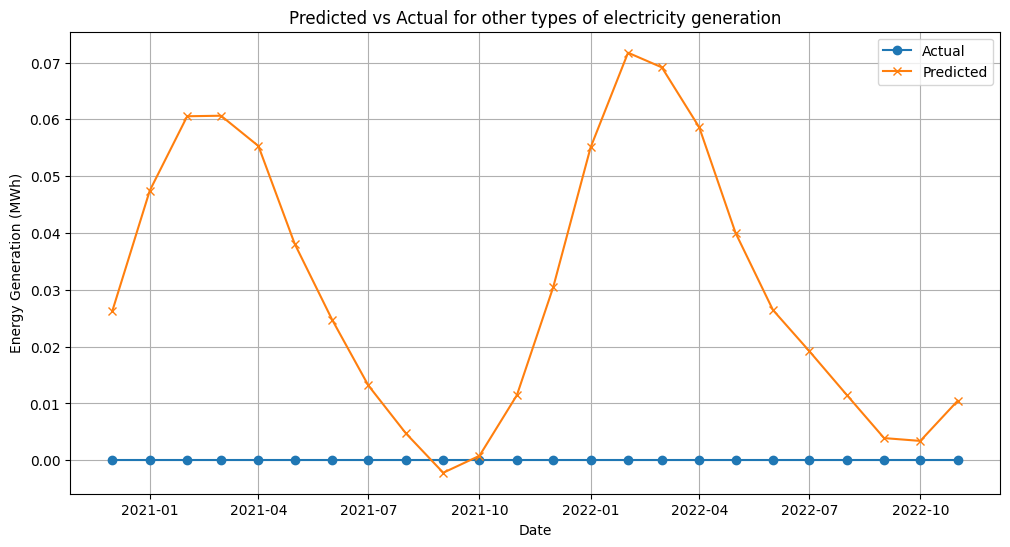

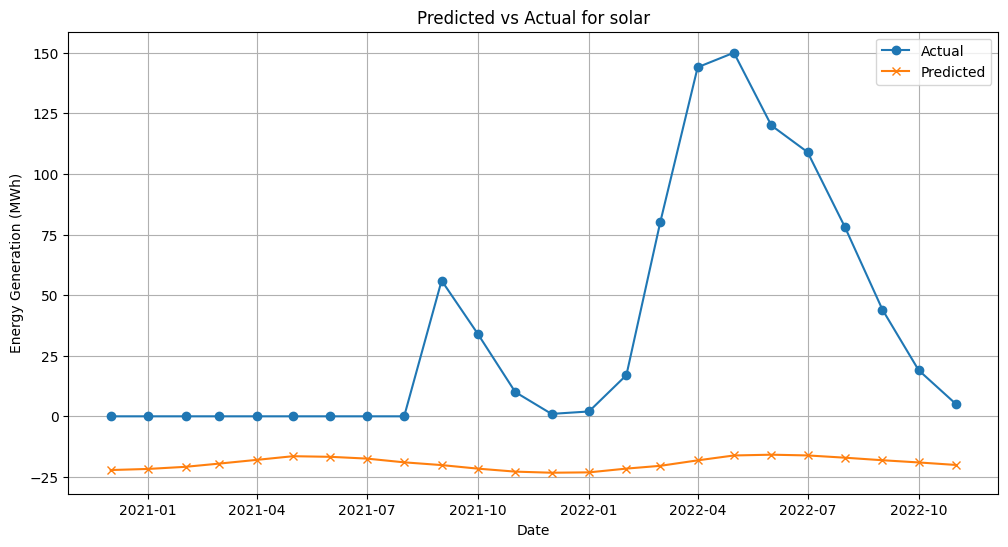

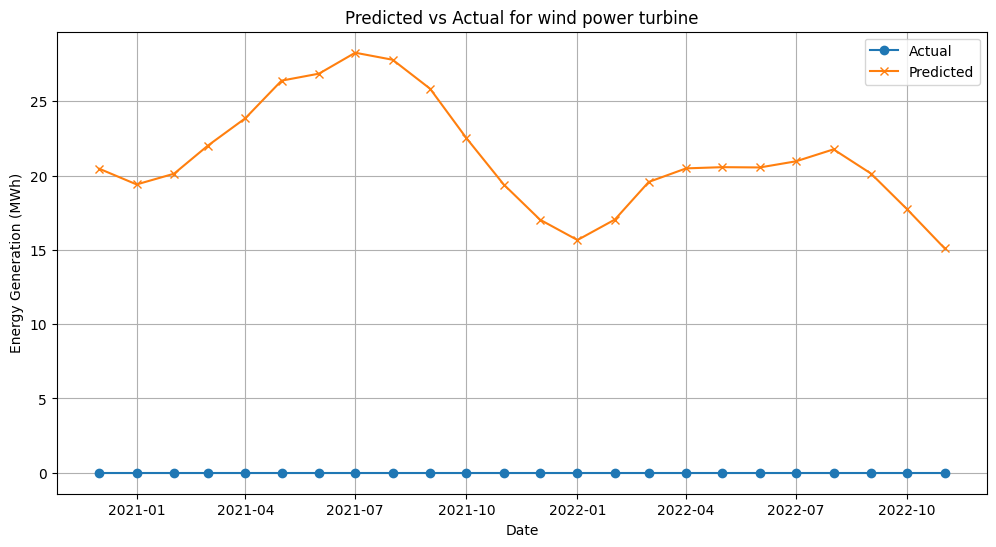

In [ ]:
# Predict on the test set
y_pred_test = tcn_model.predict(X_test)

# Rescale predictions and actual values back to their original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)

# Align the lengths for comparison
test_dates = df_pivot.index[-test_size:]
min_length = min(len(test_dates), len(y_test_rescaled), len(y_pred_test_rescaled))

# Truncate data to match lengths
test_dates = test_dates[:min_length]
y_test_rescaled = y_test_rescaled[:min_length]
y_pred_test_rescaled = y_pred_test_rescaled[:min_length]

# Convert to DataFrame for easier handling
comparison_df = pd.DataFrame(
    data=y_test_rescaled,
    index=test_dates,
    columns=df_pivot.columns
).rename_axis("Date")

predicted_df = pd.DataFrame(
    data=y_pred_test_rescaled,
    index=test_dates,
    columns=df_pivot.columns
).rename_axis("Date")

# Combine actual and predicted values into a single DataFrame for plotting
combined_df = pd.concat(
    [comparison_df.add_suffix(' (Actual)'), predicted_df.add_suffix(' (Predicted')], 
    axis=1
)

# Plot all generation types on the same figure
plt.figure(figsize=(16, 8))
for generation_type in df_pivot.columns:
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Actual)'], label=f'{generation_type} (Actual)', marker='o')
    plt.plot(combined_df.index, combined_df[f'{generation_type} (Predicted'], label=f'{generation_type} (Predicted)', linestyle='--')

plt.title("Predicted vs Actual for All Generation Types")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()



Epoch 1/50
5/5 - 5s - loss: 0.0226 - mae: 0.0990 - 5s/epoch - 946ms/step
Epoch 2/50
5/5 - 5s - loss: 0.0210 - mae: 0.0991 - 5s/epoch - 971ms/step
Epoch 3/50
5/5 - 5s - loss: 0.0193 - mae: 0.0960 - 5s/epoch - 971ms/step
Epoch 4/50
5/5 - 5s - loss: 0.0198 - mae: 0.1001 - 5s/epoch - 983ms/step
Epoch 5/50
5/5 - 5s - loss: 0.0193 - mae: 0.0992 - 5s/epoch - 977ms/step
Epoch 6/50
5/5 - 5s - loss: 0.0188 - mae: 0.0979 - 5s/epoch - 967ms/step
Epoch 7/50
5/5 - 5s - loss: 0.0191 - mae: 0.0974 - 5s/epoch - 1s/step
Epoch 8/50
5/5 - 5s - loss: 0.0184 - mae: 0.0971 - 5s/epoch - 985ms/step
Epoch 9/50
5/5 - 5s - loss: 0.0169 - mae: 0.0930 - 5s/epoch - 976ms/step
Epoch 10/50
5/5 - 5s - loss: 0.0179 - mae: 0.0947 - 5s/epoch - 1s/step
Epoch 11/50
5/5 - 5s - loss: 0.0163 - mae: 0.0909 - 5s/epoch - 1s/step
Epoch 12/50
5/5 - 5s - loss: 0.0175 - mae: 0.0958 - 5s/epoch - 999ms/step
Epoch 13/50
5/5 - 5s - loss: 0.0172 - mae: 0.0932 - 5s/epoch - 980ms/step
Epoch 14/50
5/5 - 5s - loss: 0.0161 - mae: 0.0911 - 5s/e

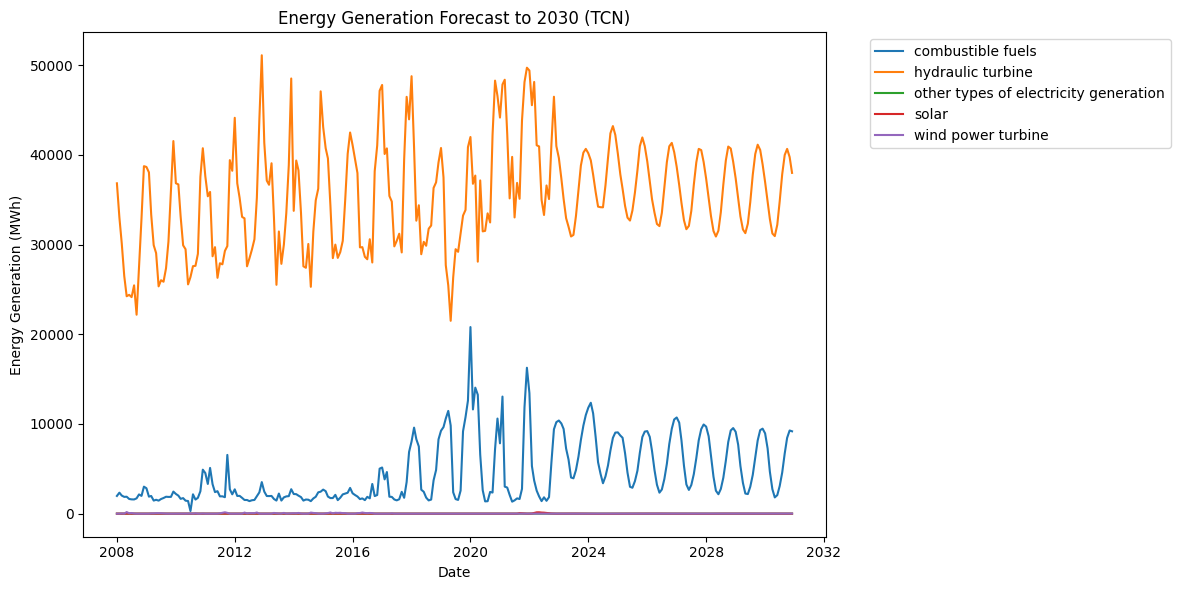

In [42]:
# Retrain the model on the entire dataset
X_full, y_full = create_sequences(data_scaled, n_steps)  # Use the entire scaled dataset for sequences

# Retrain the model
tcn_model.fit(
    X_full, y_full,
    epochs=50,  # Number of epochs can be adjusted based on requirements
    batch_size=32,
    verbose=2
)

# Forecast future energy generation
def forecast_future(model, data_scaled, scaler, n_steps, forecast_horizon, columns):
    forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, data_scaled.shape[1])
    forecast = []
    for _ in range(len(forecast_horizon)):
        prediction = model.predict(forecast_input)
        forecast.append(prediction[0])
        forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    forecast_rescaled = scaler.inverse_transform(forecast)
    return pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=columns)

# Define forecast horizon
forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')

# Generate forecasts
forecast_df_tcn = forecast_future(tcn_model, data_scaled, scaler, n_steps, forecast_horizon, df_pivot.columns)

# Plot forecasted values
def plot_forecasts(df_pivot, forecast_df, title):
    combined = pd.concat([df_pivot, forecast_df])
    plt.figure(figsize=(12, 6))
    for column in df_pivot.columns:
        plt.plot(combined.index, combined[column], label=column)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Energy Generation (MWh)")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Plot forecast
plot_forecasts(df_pivot, forecast_df_tcn, "Energy Generation Forecast to 2030 (TCN)")
